In [2]:
import pandas as pd
import numpy as np
import random
import math
import joblib
import scipy
from tqdm import tqdm
from scipy.stats import chi2_contingency, kstest, ks_2samp, ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [128]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
# !unzip bank.zip

In [8]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
df.shape

(45211, 17)

# Обработка датасета

#### y

In [10]:
df["y"] = pd.factorize(df['y'])[0]
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


#### Age

In [11]:
intervals = []

beg = 0
for i in [27, 40, 55, 100]:
    intervals.append([beg, i])
    beg = i + 1
    
intervals   

[[0, 27], [28, 40], [41, 55], [56, 100]]

In [12]:
intervals_np = np.array(intervals)

df['age'] = np.digitize(df['age'], intervals_np[:, 0]) - 1

In [13]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,3,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,2,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,1,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,2,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,1,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


<Axes: xlabel='age', ylabel='Count'>

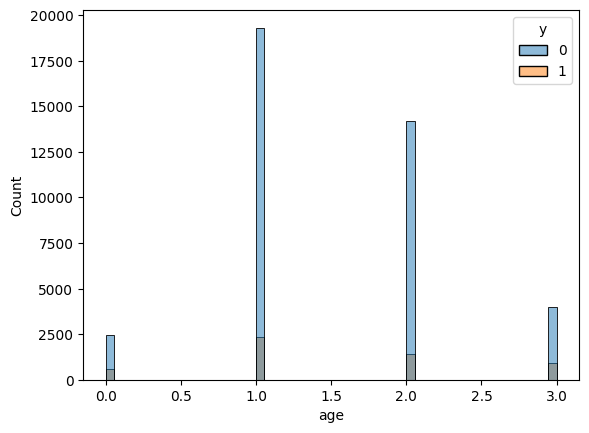

In [14]:
sns.histplot(data=df, x='age', hue='y')

#### job column

In [15]:
df = df[df['job'] != 'unknown']

In [16]:
df['job'] = pd.factorize(df['job'])[0]

#### martial column

In [17]:
df = df[df['marital'] != 'unknown']

In [18]:
df['marital'] = pd.factorize(df['marital'])[0]

<Axes: xlabel='marital', ylabel='Count'>

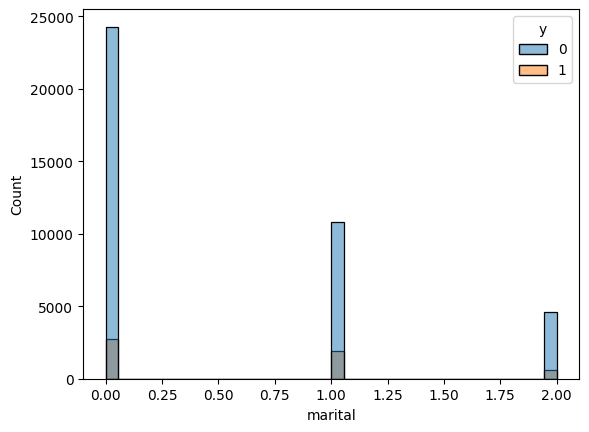

In [19]:
sns.histplot(data=df, x='marital', hue='y')

#### education column

In [20]:
df['education'] = pd.factorize(df['education'])[0]

In [21]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,3,0,0,0,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,2,1,1,1,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,1,2,0,1,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,2,3,0,2,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
5,1,0,0,0,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,2,1,0,0,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,3,4,2,3,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,3,4,0,1,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,3,3,0,1,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


<Axes: xlabel='education', ylabel='Count'>

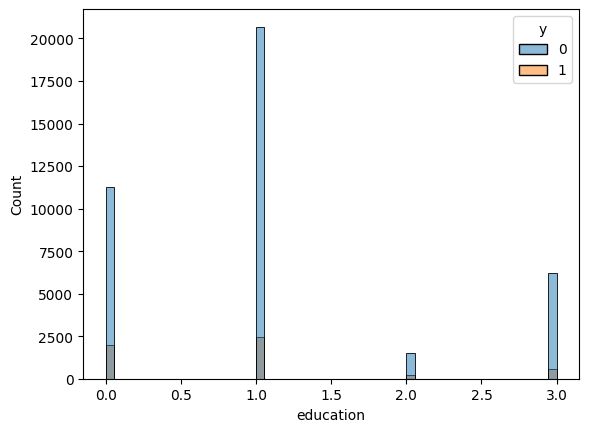

In [22]:
sns.histplot(data=df, x='education', hue='y')

#### default column

<Axes: xlabel='default', ylabel='Count'>

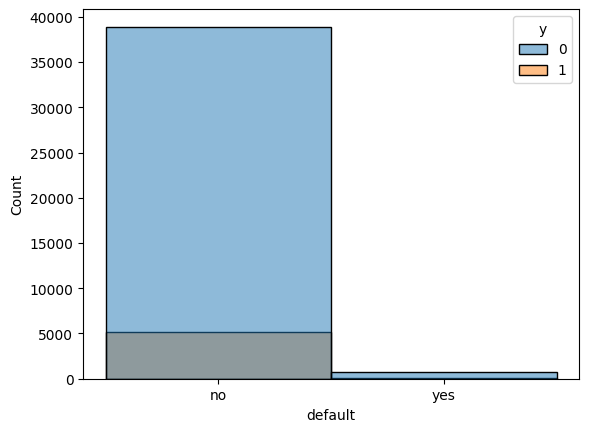

In [23]:
sns.histplot(data=df, x='default', hue='y')

In [24]:
df['default'] = pd.factorize(df['default'])[0]

In [25]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

#### balance column

In [26]:
df['balance']

0        2143
1          29
2           2
3        1506
5         231
         ... 
45206     825
45207    1729
45208    5715
45209     668
45210    2971
Name: balance, Length: 44923, dtype: int64

#### housing and loan

<Axes: xlabel='housing', ylabel='Count'>

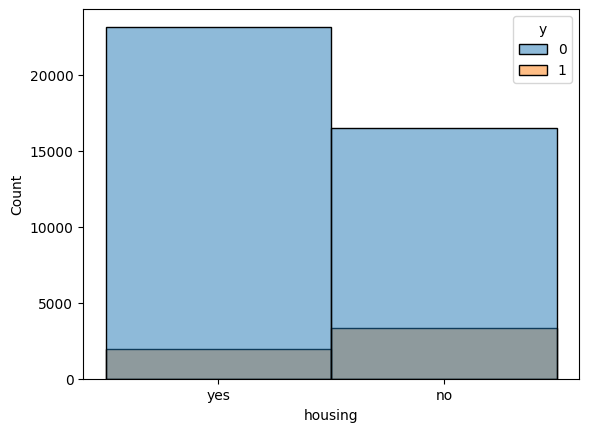

In [27]:
sns.histplot(data=df, x='housing', hue='y')

In [28]:
df['housing'] = pd.factorize(df['housing'])[0]

<Axes: xlabel='loan', ylabel='Count'>

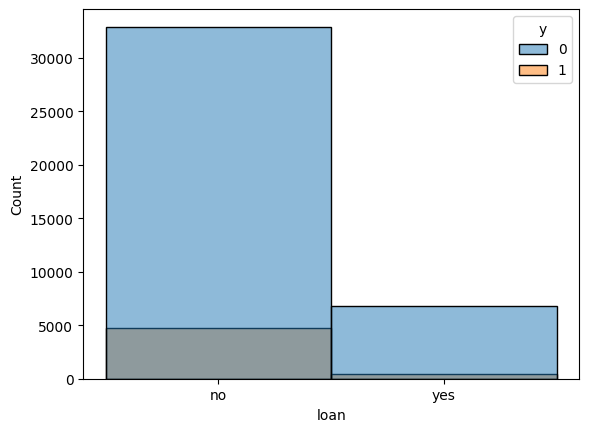

In [29]:
sns.histplot(data=df, x='loan', hue='y')

#### contact & campaign & poutcome

<Axes: xlabel='contact', ylabel='Count'>

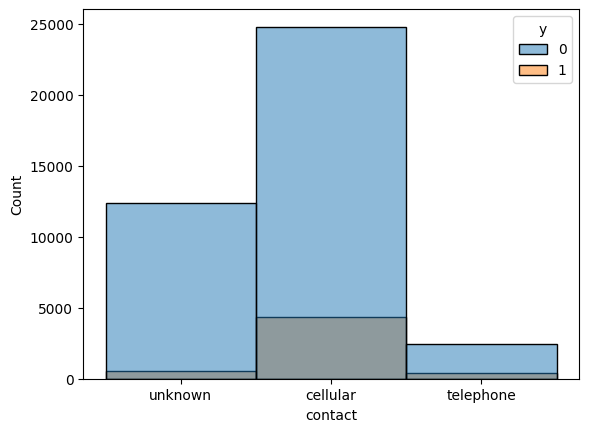

In [30]:
sns.histplot(data=df, x='contact', hue='y')

<Axes: xlabel='campaign', ylabel='Count'>

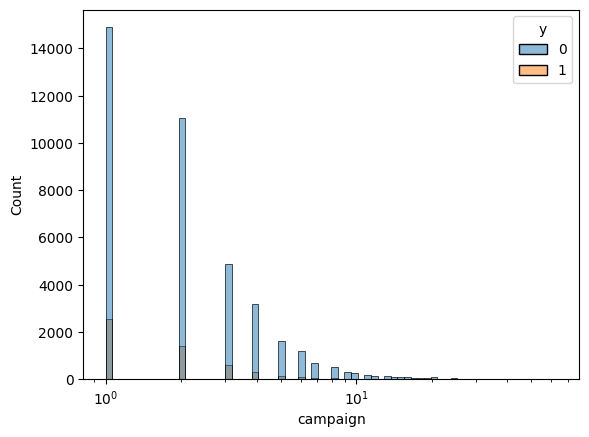

In [31]:
sns.histplot(data=df, x='campaign', log_scale=True, hue='y')

<Axes: xlabel='poutcome', ylabel='Count'>

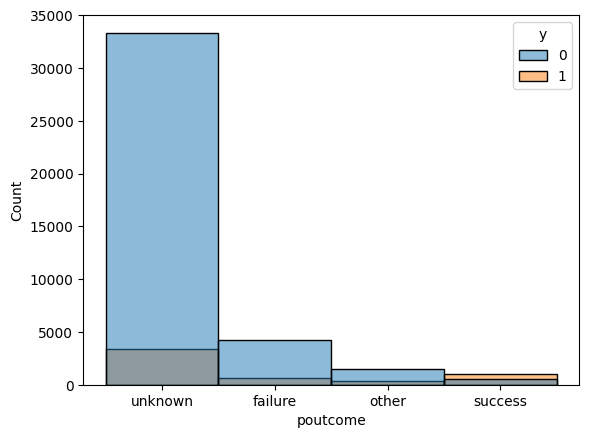

In [32]:
sns.histplot(data=df, x='poutcome', hue='y')

In [34]:
df['ID'] = df.index.astype(int)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,ID
0,3,0,0,0,0,2143,0,no,unknown,5,may,261,1,-1,0,unknown,0,0
1,2,1,1,1,0,29,0,no,unknown,5,may,151,1,-1,0,unknown,0,1
2,1,2,0,1,0,2,0,yes,unknown,5,may,76,1,-1,0,unknown,0,2
3,2,3,0,2,0,1506,0,no,unknown,5,may,92,1,-1,0,unknown,0,3
5,1,0,0,0,0,231,0,no,unknown,5,may,139,1,-1,0,unknown,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,2,1,0,0,0,825,1,no,cellular,17,nov,977,3,-1,0,unknown,1,45206
45207,3,4,2,3,0,1729,1,no,cellular,17,nov,456,2,-1,0,unknown,1,45207
45208,3,4,0,1,0,5715,1,no,cellular,17,nov,1127,5,184,3,success,1,45208
45209,3,3,0,1,0,668,1,no,telephone,17,nov,508,4,-1,0,unknown,0,45209


In [35]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'ID'],
      dtype='object')

In [36]:
cat_features = ['age', 'job', 'marital', 'education', 'housing', ]
num_features = ['balance']

In [37]:
strat_features = ['age', 'job', 'education', 'balance', 'housing']

# Стратификация Сбера

In [38]:
def get_base_stratification(df, df_aa, p_key:str, part):  
    
        
    ERR=0
    flag_group = 0
    mes = ""
    
        
    if(p_key not in df.columns):
        ERR = 1
        mes = "ОШИБКА: В данных не найден столбец содержащий объекты деления!"
        
    elif(len(df.columns)<2):  
        ERR = 2
        mes = "ОШИБКА: Не найдены столбцы с критериями однородности!"
        
    elif(df[p_key].duplicated().any() == True):   
        ERR = 3
        mes = "ОШИБКА: В ключевом столбце найдены дубликаты! Значения должны быть уникальными." 
        

    if(ERR > 0): # Если есть ошибки, то запуск деления не возможен    
        
        print(mes)
        
        return ERR
        
    else:
        
        df = sorting_features(df_res = df, p_key = p_key) # сортируем фичи по типу, чистим данные
    
        form_strat_ = form_strat(df, part) # формируем страты
        return form_strat_

## Формирование страт

In [40]:
# Формирование страт
"""
Функция скрипта:  формирование страт.

Входящие параметры: 
df – таблица с данными по участникам
part - количество групп, формат – целые числа, в MVP0 значение всегда 2

"""
    
def form_strat(df, part):
    
    features = []
    strat_feature = []
    features_strat = ['age : xi2', 'job : xi2', 'education : xi2', 'balance : ks', 'housing : xi2']
    
    kombo={}
    strat_kombo = {}
    strat = {}
    
    for i in df.columns:  
        if(i in features_strat):
            if('ks' in i):
                df[i.replace('ks', 'interval')] = interval_combo(df[i]) # формируем интервалы из числовых фичей
                features.append(i.replace('ks', 'interval'))
            else:
                features.append(i)   
# группируем данные
    for i in features:          
        strat_feature.append({i:df.groupby(i).groups})


    for i in strat_feature:
        for k in i:        
        
            iloc={}
        
            kombo[k] = iloc
        
            for j in i[k]:        
            
                iloc[k+"_"+str(j)] = list(i[k][j])


    for q in range(len(features)):
        
        if(q == 0):
            col_unic = kombo[features[q]]
        else: 
            col_unic = strat
    
        if(q+1<len(features)):
            strat = {}
    
            for e in col_unic:
            
                for r in kombo[features[q+1]]:
                    cells_strat = list(set(col_unic[e]) & set(kombo[features[q+1]][r]))
                    

                    
                    #print("Последний столбец:",features[q])
                    if(q == len(features)-2):
                        #print("Последний столбец:",features[q])
                        if(len(cells_strat)>0): # если страта не пустая \ больше или равна кол-ву групп, записываем участников
                            
                            if(len(cells_strat)<part):
                                if("one_strat" not in strat):
                                    strat["one_strat"] = cells_strat
                                else:    
                                    strat["one_strat"].append(cells_strat[0])
                            #elif(len(cells_strat)==3 and part == 2):
                               # strat[(str(e)+"__"+str(r)).replace(" : xi2", "")] = cells_strat[:2]
                               # if("one_strat" not in strat):
                                    #strat["one_strat"] = cells_strat[2]
                                #else:    
                                    #strat["one_strat"].append(cells_strat[2])
                                #print("\n","Три участника страты:", strat[(str(e)+"__"+str(r)).replace(" : xi2", "")], cells_strat[:2])
                      #print("Нормальная страта:", (str(e)+"__"+str(r)).replace(" : xi2", ""))
                            else:
                                strat[(str(e)+"__"+str(r)).replace(" : xi2", "")] = cells_strat
                        
                    else:    
                        
                        strat[(str(e)+"__"+str(r)).replace(" : xi2", "")] = cells_strat
                        
    if(len(strat)==0):
        strat={'one_strat': list(df.index)}
  
    return strat  



## Отбор числа участников из страты

#### Пропорциональное размещение

Общая сумма участников всех страт - Все участники ГС - находим долю конкретной страты. 

Смотрим, сколько участников теста нам нужно. От этого нового количества n вычисляем n_h то вычисленной доле.

#### Алгорит нахождения кол-ва участников в страте и вычитания из нее необходимого числа.

Правила и исключения

* Страта очень маленькая - ее нужно присоеденить 
* При округлении кол-ва участников страты общиее количество участников теста получилось меньше, чем заявленное из-за погрешности округления - придумать правило 

### Формирование интервалов для числовых фичей

### Метод процентилей

In [41]:
"""
Функция скрипта:  формирование интервалов в числовой фиче.

Входные параметры скрипта:
s – отдельная фича, столбец

На выходе скрипта:

s_percentile, столбец содержащий интервалы для фичи, которая загружалась при вызове скрипта. 

"""

def interval_combo(s):
    
    s_percentile = pd.Series(list(s.values), index=list(s.index)) 
    
    p = [0.5, 0.25, 0.05] 
    
    for i in p:
        s_percentile[list(s[(s<s.quantile(q=i))].index)] = i
        s_percentile[list(s[(s>=s.quantile(q=1.0-i))].index)] = i
        
    s_percentile[list(s[(s == 0)].index)] = 0 # ноль выделяем в отдельный интервал 
    s_percentile[list(s[(s < 0)].index)] = -1 # минусовые значения выделяем в отдельный интервал - т.к. убытки
     
            
    return s_percentile


## Сводный скрипт стратификации

In [42]:
"""
Функция скрипта:  сортировка фичей по критериям + чистка данных в фичах.

Входящие параметры: 
df_res – таблица с данными участников
p_key -  p_key – название ключевого столбца (содержит объекты деления), формат – строковый, 
значение берется из входного параметра p_key скрипта, который вызывает скрипт sorting_features

flag_aa = False - флаг АА-теста, выбор будет ли проводиться АА-тест или стандартная проверка на однородность.

"""

def sorting_features(df_res, p_key:str, flag_aa = False): # сортировка фичей по критериям + чистка данных в фичах
    
    features_ks = ['balance']
    features_xi2 = ['age', 'job', 'education', 'housing']
    features_case = []

    list_kriterii=[]

    for i in df_res.columns:  
        
        #print(i,'тип фичи', df_res[i].dtype)
        
        if((i == p_key) or (i == 'group_num') or ("ks" in i) or ("xi2" in i) or ("interval" in i) or ("tt" in i)):
            list_kriterii.append(i)
            
        else:
                    
            if(i in features_xi2):
                #print("Хи2 1", i)
                list_kriterii.append(i+" : xi2")
                
            elif(i in features_ks and (df_res[i].dtype == np.float64 or df_res[i].dtype == np.int64) and flag_aa == False):
                #print("ks", i)
                list_kriterii.append(i+" : ks")
            
            elif(df_res[i].dtype != np.float64 and df_res[i].dtype != np.int64):
                #print("Нужна чистка", i)
                
                # чистка данных в  фиче
                df_res[i] = df_res[i].replace({'null':np.nan, 'Null':np.nan,'NULL':np.nan,'nan':np.nan,'Nan':np.nan,'NaN':np.nan,'NAN':np.nan,'-':np.nan, '':np.nan, ' ':np.nan})          
                
                try:
                    # перевод фичи в числовой формат
                    df_res = df_res.astype({i: "float64"})
                except:  
                    if(i in features_ks or i in features_case):
                        print("Ошибка при переводе в числовой формат фичи:", i, " Данные в фиче не относятся к числовым, требуется замена данных.")
                         
            # анализ данных в фиче, после чистки данных
            
            if(i +" : ks" not in list_kriterii and i+" : xi2" not in list_kriterii and i+" : tt" not in list_kriterii): 
                if(flag_aa == True and (df_res[i].dtype == np.float64 or df_res[i].dtype == np.int64)):
                    list_kriterii.append(i+" : tt")
                
                elif(df_res[i].nunique()>7 and (df_res[i].dtype == np.float64 or df_res[i].dtype == np.int64)):
                        #print("KS", i)                
                        list_kriterii.append(i+" : ks")
                    
                else:
                    #print("Хи2 2", i)
                    list_kriterii.append(i+" : xi2")
                    
           
                
    df_res.columns = list_kriterii                
    return df_res


### Проверка однородности - получаем p-value

In [43]:
# скрипт хи2

def ser_conjugacy(ser, index):
    zero=[]        
    index_plus = list(set(index) - set(ser.index.tolist()))
 
    for i in range (len(index_plus)):
        zero.append(0)
    
    return pd.concat([ser, pd.Series(zero, index=index_plus)]) 

"""
Функция скрипта: Построение таблицы сопряженности с учетом малонаполненных подгрупп, проведение стат. теста Хи2.

Входящие параметры: 
gr_A - данные участников по столбцу от одной группы
gr_B - данные участников по столбцу от другой группы


"""

def check_homo_cat_xi2_other(gr_A,gr_B): 
    nonhomo={}
    other={}
    count=0

    # строим таблицу сопряженности
    gr_B=gr_B.groupby(gr_B).count()
    gr_A=gr_A.groupby(gr_A).count()
    index_= pd.Series(gr_B.index.tolist()+gr_A.index.tolist())
    index_= index_.groupby(index_).count().index.tolist()
    
    gr_B = ser_conjugacy(gr_B, index_)
    gr_A = ser_conjugacy(gr_A, index_)    
   
    merge_data=pd.DataFrame()
    merge_data['id_x']=gr_A
    merge_data['id_y']=gr_B
    merge_data=merge_data.fillna(0)     # заполнение пропусков нулями
   
    # Обрабатывем малонаполненные группы
    count_sub_gr=(merge_data['id_x']+merge_data['id_y']).sort_values()    
    
    
    # если есть малонаполненные подгруппы, то объединяем их
    for i in count_sub_gr.index:   
           
        if((count_sub_gr.loc[i]<=15) or (count==1)):
            
            if(count==0):                                          
                other = {'id_x': merge_data['id_x'].loc[i],'id_y':merge_data['id_y'].loc[i]}   
                
            else:  
                other = {'id_x': merge_data['id_x'].loc[i]+other['id_x'],'id_y':merge_data['id_y'].loc[i]+other['id_y']}  
            
            count+=1
            merge_data.drop(labels = [i],axis = 0, inplace = True)                
            
            
    if(len(other)>0):                
            merge_data = pd.concat([merge_data, pd.DataFrame([other],index =['Прочее'])]) # , ignore_index=True
    #print("\n")  
    
          
    pvalue = chi2_contingency(merge_data[["id_x","id_y"]])[1]    
        
    #print('p-value:', round(pvalue,5))    
    if (str(pvalue)=='nan'):       
        
        pvalue = 0
        
    
    return pvalue


In [44]:
# Тест Колмогорова-Смирнова

"""
Функция скрипта: Проведение стат. теста Колмогорова-Смирнова.

Входящие параметры: 
gr_A - данные участников по столбцу от одной группы
gr_B - данные участников по столбцу от другой группы
alpha  –  уровень значимости, формат – дробное число, значение берется из входного параметра alpha  скрипта, который вызывает  скрипт ks_test

"""
def ks_test(gr_A,gr_B,alpha):
    ks_test=ks_2samp(gr_A,gr_B)[1]
    #if(ks_test<alpha):
        #print("Колмогоров-Смирнов, НЕ однородны: р=",ks_test)    
    #else:
        #print("Колмогоров-Смирнов, однородны: р=",ks_test) 
    
    return ks_test
    


In [45]:
"""
Функция скрипта: проверка однородности, формирования отчета по фичам
Входящие параметры: 

•	df_res – таблица сформированная скриптами random_strat или multy_group•	
•	alpha  –  уровень значимости, формат – дробное число, значение берется из входного параметра alpha  скрипта, который вызывает  скрипт checking_uniformity
•	p_group - название столбца с указанием принадлежности к группе таблицы df_res, формат - строковый, если скрипт вызывается скрипами random_strat или multy_group, значение «».
•	part -  количество групп, формат – целые числа, значение берется из входного параметра part скрипта, который вызывает скрипт checking_uniformity
"""

def checking_uniformity(df_res, p_group:str, part, alpha):
    flag_group=0      

    
    df_report = pd.DataFrame()    
    df_report_new  = pd.DataFrame()
    
    
    for i in df_res.columns:   
                        
        if('Unnamed' in i):                
            df_res.drop(i, axis=1, inplace=True)
            
        elif(('xi2' in i) or ('ks' in i) or ('tt' in i)):
                        
            
#####################################################################################################3                        
               
                        # проверка на две группы  
            if(part==2):
                #print("две группы")
                        
                gr_A=df_res[(df_res["group_num"] == 0 )][i] 
                gr_B=df_res[(df_res["group_num"] == 1 )][i]                         
                        
                    # если распределение биноминальное или категориальное - отправляем на хи2, кат - не более 7 уникальзых значений. 
                
                
                
                if('xi2' in i):
                            
                    #print("бином или категория", i, df_res[i].dtypes)  #фича на хи2                    
                    p_value = check_homo_cat_xi2_other(gr_A,gr_B)
                    #res=[i,p_value,alpha] 
                    
                        #break  
                            
                            
                elif('ks' in i):     
                    # числовые отправляются на критерий Колмогорова-Смирнова
                    #print("колмогоров", i, df_res[i].dtypes)  
                    
                    p_value = ks_test(gr_A,gr_B,alpha) 
                    #res=[i,p_value,alpha] 
                     # Заполняем данными по итерации датафрейм сплитовалки  
                elif('tt' in i):   
                    
                    p_value = t_test(gr_A,gr_B, alpha)
                    
                        #break #если однородность не найдена на одной из колонок, следующие не проверяются, переход к следующей итерации
            # если нет однородности
                
                if(p_value < alpha):                        
                    flag = 0  
                else:
                    flag = 1
                    
            df_report_new = pd.DataFrame({'features':i, 'p-value':p_value, 'alpha':alpha, 'flag':flag},index = [0])
        
            df_report = pd.concat([df_report, df_report_new], ignore_index=True)
                        
    
    if(df_report['flag'].nunique()==1 and df_report['flag'].unique()==1):
        flag_group = 1 
    #print("Флаг однородности:", flag_group)
    
    # flag_group = 1, значит однородно
    return flag_group, df_report 
 

### Отбор и деление

In [46]:
# деление на группы

"""
Функция скрипта: деление на группы 

Входящие параметры: 
df - данные по участникам страты, формат – таблица,
part - количество групп, формат – целые числа.

"""
def find_group(df,part:int):        
    
    df_new = pd.DataFrame()
    df_res = pd.DataFrame()
    
    if(len(df)>0):
        n_h = len(df)
        df.reset_index(drop=True, inplace=True) # сбрасываем индексы
        n_h_group = round(n_h/part)
        
        if(n_h_group > 0):
            for i in range(part):          
            
                if(i!=(part-1)): 
                
                                   
                        df_new=df.sample(n=n_h_group)             
                        df=df[~df.index.isin(df_new.index)]  
            
                else:    
                    df_new=df
            
        
                df_new['group_num']=i    
                df_res = pd.concat([df_res, df_new], ignore_index=True) #
        
        
    return df_res   

In [47]:
"""
Функция скрипта: При репрезентативном отборе пропорционально вычисляет размер страты для тестовой выборки.

Входящие параметры: 
df_strat – данные по участникам страты, формат – таблица
n_gs – количество участников в ГС, формат - целые числа
n – количество участников в выборке, формат - целые числа
part - количество групп, формат – целые числа, в MVP0 значение всегда 2.

"""

def select_prop(df_strat, n_gs:int, n:int, part:int):
    
    per_strat = len(df_strat)/n_gs # находим процент, занимаемый стратой в ГС
        
    
    n_h =  round(n*per_strat) 
    if(n_h > 0 and n_h < part):
        n_h = part # отрез участников для малых страт    
        
    if(part == 2 and n_h==3):
        n_h = 2
        
       # рандомно выбераем из страты нужное кол-во участников в выборку
    if(n_h > 0):       
        df_strat = df_strat.sample(n=n_h) 
    else:
        df_strat = pd.DataFrame()

        
    return df_strat
 

In [48]:
"""
Входные параметры скрипта:
gr_A - данные участников по столбцу от одной группы
gr_B - данные участников по столбцу от другой группы
alpha  –  уровень значимости, формат – дробное число, значение берется из входного параметра alpha  скрипта, который вызывает  скрипт ks_test

"""

def t_test(gr_A,gr_B, alpha):
    
    # t-тест с разными дисперсиями модификация Уэлша
    stat, p_value = ttest_ind(gr_A, gr_B, equal_var=False)[:2]  
    #if(p_value<alpha):
        #print("t-test, НЕ однородны: р=",ks_test)    
    #else:
        #print("t-test, однородны: р=",ks_test) 
    return  p_value 
    

In [49]:
"""
Входные параметры скрипта:
df_aa - данные включающие ключевой столбец идентичный таблице df и фичи для проведения АА-теста, формат – таблица;
df – данные включающие ключевой столбец и фичи с признаками однородности, формат – таблица;
part - количество групп, формат – целые числа, в MVP0 значение всегда 2.
p_key – название ключевого столбца, формат - строковый
alpha – уровень значимости, формат – дробное число, по умолчанию 0.05
representative – флаг репрезентативного отбора, если True, то репрезентативный отбор производится.

"""

def aa_test(df_aa, df, p_key:str ,part:int, alpha:float, representative:bool):
    
    #print('Колонки датасета АА -аа',df_aa.columns)
    
    df = df[['group_num']]
    df_aa = df_aa.sort_values(by = p_key, inplace=False)  
    df_aa = df_aa.astype({p_key: "str"})
    df_aa = df_aa.set_index(p_key)
        
    # Если есть репрезентативный отбор
    if(representative == True):
   
        df_aa=df_aa[df_aa.index.isin(df.index)] 
    #
    df_aa["group_num"] = df["group_num"].values
    
    # чистим данные
    df_aa = sorting_features(df_aa, p_key, True)
    
    
    # проверка однородности      
    flag_aa, df_report_test_aa = checking_uniformity(df_aa, p_group = "group_num", part = part, alpha = alpha)
   
    #print('df',"\n", df.head())
    #print("\n")
    #print('df_aa',"\n",df_aa.head())
    #print("\n")  
    if(len(df) == len(df_aa)):
        
        return flag_aa, df_report_test_aa, df_aa
    

# Код генетического алгоритма

In [50]:
df_inp = df[['ID'] + strat_features]
df_aa = df[['ID', 'y']]

In [52]:
%%time

min_sample_in_group = 2
atomic_strats = get_base_stratification(df_inp, df_aa, p_key="ID", part=min_sample_in_group)  

Общее количество участников ГС 44923


CPU times: user 1.33 s, sys: 2.41 ms, total: 1.33 s
Wall time: 1.33 s


In [53]:
len(atomic_strats.keys())

1072

In [54]:
# Подсчитываем дисперсию при базовом разбиении и сэмплирвоании с учетом дисперсии

def sample_strata_sizes_(df, strata_dict, p_key, target_df, n):
    stds = []
    sizes = []
    
    for i in strata_dict:

        df_strat = df[df[p_key].astype(int).isin(strata_dict[i])]

        y = target_df.loc[target_df[p_key].isin(df_strat[p_key]), 'y']
        stds.append(y.values.std())
        sizes.append(y.shape[0])
        
    sizes =  np.array(sizes)
    stds = np.array(stds)
    n_h = (sizes * stds * n) / np.sum(stds * sizes)

    return n_h

def sample_from_strata_(df_strat, n_gs, n, n_h=None):
    if n_h is None:
        # simple sampling (proportional)
        per_strat = len(df_strat) / n_gs
        n_h = round(n * per_strat)

    if(n_h > 0):       
        df_strat = df_strat.sample(n=n_h)
        # print(df_strat.ID, '\n')
    else:
        df_strat = pd.DataFrame()

        
    return df_strat


def calc_stratified_var_(df, target_df, weights, p_key='ID'):
    var = 0
    for group in df.groupby(by=['strat'], sort=False):

        ids = group[1][p_key].values
        # print(ids)
        N = weight * len(df_inp)
        
        weight = weights[group[0]]
        if len(target_df.loc[target_df[p_key].isin(ids), 'y'].values) > 1:
            var += weight * target_df.loc[target_df[p_key].isin(ids), 'y'].values.var(ddof=1)
        # print(var)
        
    return var


n = 2_000

weights = {}              
for strata in atomic_strats:
    weights[strata] = len(atomic_strats[strata]) / df_inp.shape[0]


n_h = sample_strata_sizes_(df_inp, atomic_strats, "ID", df_aa, n)
n_h = np.round(n_h).astype(int)
print(n_h, '\n', np.sum(n_h))

df_res_all_strat_std = pd.DataFrame()
j = 0

stratified_var_ = 0
for i in atomic_strats:    # производим операции над каждой стратой
    df_strat = df[df["ID"].astype(int).isin(atomic_strats[i])]
    # df_strat['strat'] = i
    N = df_strat.shape[0]
    
    var = df_aa.loc[df_aa.ID.isin(df_strat.ID), "y"].values.var(ddof=1)
    if n_h[j] > 0:
        stratified_var_ += N ** 2 * (1 - n_h[j] / N) * ( var / n_h[j])

    j += 1

stratified_var_


[1 0 0 ... 2 0 5] 
 1984


78239.19117415108

In [55]:
V_min = stratified_var_
V_min

78239.19117415108

In [56]:
atomic_strats_keys = list(atomic_strats.keys())

In [57]:
atomic_strats_ind = list(range(len(atomic_strats_keys)))

In [58]:
atomic_strata_by_ind = dict(zip(atomic_strats_ind, list(atomic_strats.values())))

In [59]:
p_key = 'ID'
target_column = 'y'

variances = []
means = []

for key in atomic_strats_keys:
    data = df[df[p_key].astype(int).isin(atomic_strats[key])]
    if len(data) <= 1:
        variances.append(0.0)
    else:
        variances.append(data[target_column].values.var(ddof=1))
    means.append(data[target_column].values.mean())

In [64]:
var_dict = dict(zip(atomic_strats_ind, variances))
mean_dict = dict(zip(atomic_strats_ind, means))

In [65]:
P_KEY = 'ID'
TARGET_COLUMN = 'y'
TOTAL_SIZE = df_inp.shape[0]
NORM_CONST = df_inp.shape[0]


def stratified_var():
    pass
    

def join_vars_sizes(atomic_strats_numbers):
    """
    Подсчет дисперсии в новом объединении атомарных страт
    """
    new_mean = join_means(atomic_strats_numbers)
    var = 0
    total_size = 0
    for i in atomic_strats_numbers:
        size = len(atomic_strata_by_ind[i])
        total_size += size


        var += (size - 1) * var_dict[i] + size * (mean_dict[i] - new_mean) ** 2

    if total_size <= 1:
        return 0.0, total_size

    return var / (total_size - 1), total_size


def join_means(atomic_strats_numbers):
    """
    Подсчет среднего в новом объединении атомарных страт
    """
    mean = 0 
    total_size = 0
    for i in atomic_strats_numbers:
        size = len(atomic_strata_by_ind[i])
        total_size += size
        mean += (mean_dict[i] * size)
    return mean / total_size


def minimize_var_solution(all_strats, n):
    """
    Подсчет оптимальных пропорций при сэмплирвоании из страт
    strats - list[list] -- лист с элементами (номерами атомарных страт) задающий новую стратификацию
    """
    stds = []
    sizes = []
    for strata in all_strats:
        if len(strata) == 0:
            stds.append(0)
            sizes.append(0)
            continue
        var, size = join_vars_sizes(strata)
        stds.append(np.sqrt(var))
        sizes.append(size)
        
    if VERBOSE:
        print(f"stds: {stds}\n")
    sizes =  np.array(sizes)
    stds = np.array(stds)  
    n_h = (sizes * stds * n) / np.sum(stds * sizes)

    return np.round(n_h).astype(int)



def calc_stratified_var(stratification, n_h):
    """
    Считаем стратифицированную дисперсию для разбиения с учетом насэмплированных элементов

    stratification - list[list] -- лист с элементами (номерами атомарных страт) задающий новую стратификацию
    """
    stratified_var = 0
    j = 0
    for strat in stratification:
        
        if VERBOSE:
            print(f'starta: {strat}\n')
            
        if len(strat) == 0:
            stratified_var += 0
        
        else:
            var, N = join_vars_sizes(strat)

            weight = N / TOTAL_SIZE
            
            if N > 1 and n_h[j] > 0:
                stratified_var += N ** 2 * (1 - n_h[j] / N) * ( var / n_h[j])
            else:
                # если выбираем только одного пользователя то его дисперсия 0
                stratified_var += 0

        if VERBOSE:
            print(f"stratified_var: {stratified_var}\n")
        j += 1
        
    return stratified_var



def create_stratification(generation_atom_dict1, generation_atom_dict2, mutation_rate):
    """
    По двум родителям порождаем новую стратификацию
    """
    C = np.random.randint(1, K) # выбрали какие атомы как размечать
    if VERBOSE:
        print(f"C: {C}\n")
    # [0,1,.., C-1] -- parent1
    # [C, C+1, .., K-1] -- parent2
    atom_dict = {}
    stratification = [[] for i in range(U)]
    for i in range(0, K):
       #  generation_atom_dict1[i] -- страта в какой лежит iая атомарная страта в первом родителе
        mutation_number = np.random.rand(1)[0]
        if mutation_number < mutation_rate:
            new_strata_index = np.random.randint(0, U)
        elif i < C:
            new_strata_index = generation_atom_dict1[i] 
        else:
            new_strata_index = generation_atom_dict2[i] 

        stratification[new_strata_index].append(i)
        atom_dict[i] = new_strata_index
        if VERBOSE:
            print(f"atom: {i}, mutation_number: {mutation_number}, new_strata_index: {new_strata_index}")
    
    if VERBOSE:
        print(f"stratification: {stratification}\n")
    return stratification, atom_dict



def produce_next_generation(generation, generation_atom_dict, elitism=0.2, mutation_rate=0.0, n=10):
    """
    generation - list[list[list]] -- лист стратификаций. Каждая стратификация - list[list] с элементами (номерами атомарных страт) входящих в данную страту
    generation_atom_dict - list[dict] -- словарь для каждой стратификации в поколении, в котором каждой атомарной страте приписано, какой страте (в текущем разбиении) она принадлежит 

    """
    global BEST_STRATS_WITH_VAR
    n_individuals = len(generation)
    next_generation_atom_dict = []
    next_generation = []

    if VERBOSE:
        print("="*10, 'counting stratified vars', "="*10, '\n')

    stratified_vars = []
    for individual in generation:
        if VERBOSE:
            print(f"\n\nindividual: {individual}\n")
        n_h = minimize_var_solution(individual, n)
        if VERBOSE:
            print(f"n_h: {n_h}\n")

        strat_var = calc_stratified_var(individual, n_h)
        if VERBOSE:
            print(f"total strat_var: {strat_var}\n")

        stratified_vars.append(strat_var)
        

    stratified_vars = np.array(stratified_vars) / NORM_CONST
    
    if VERBOSE:
        print(f"stratified_vars: {stratified_vars}\n")


    if len(stratified_vars[stratified_vars > 0]) > 0:
        masked_stratified_vars = np.ma.masked_equal(stratified_vars, 0, copy=False)

        if BEST_STRATS_WITH_VAR[1] > np.min(masked_stratified_vars):
            BEST_STRATS_WITH_VAR = (generation[np.argmin(masked_stratified_vars)], np.min(masked_stratified_vars))
        
            joblib.dump(BEST_STRATS_WITH_VAR, "best_strat_and_var_marketing2.joblib")

    probs = scipy.special.softmax(-stratified_vars)

    if VERBOSE:
        print(f"probs: {probs}\n\n\n\n")


    if VERBOSE:
        print("="*10, 'choosing best stratifications', "="*10, '\n')
    # Выбрали лучших
    part = np.round(elitism * len(generation)).astype(int)
    indexes_of_best = probs.argsort()[-part:]
    if VERBOSE:
        print(f"part: {part}, indexes_of_best: {indexes_of_best}\n")

    
    if VERBOSE:
        print("="*10, 'creating new generation', "="*10, '\n')
    for i in range(part):
        next_generation.append(generation[indexes_of_best[i]])
        next_generation_atom_dict.append(generation_atom_dict[indexes_of_best[i]])

    if VERBOSE:
        print(f"next_generation_best: {next_generation}, next_generation_best_dict: {next_generation_atom_dict}\n")

    
    # генерируем следующее поколение
    n_individuals = n_individuals - part

    for i in range(0, n_individuals):
        if VERBOSE:
            print(f"\n\n\nindividual: {i}\n")
        # выбираем двух лучших
        indexes = np.arange(0, len(generation))
        parents_indexes = np.random.choice(indexes, size=2, replace=False, p=probs)

        parent1 = generation_atom_dict[parents_indexes[0]]
        parent2 = generation_atom_dict[parents_indexes[1]]

        if VERBOSE:
            print(f"chosen parents: {parents_indexes}, dict1: {parent1}, dict2: {parent2}\n")

        child, child_atom_dict = create_stratification(parent1, parent2, mutation_rate)

        if VERBOSE:
            print(f"child: {child}, child_atom_dict: {child_atom_dict}\n")

        next_generation.append(child)
        next_generation_atom_dict.append(child_atom_dict)
    
    if VERBOSE:
        print(next_generation)
    if VERBOSE:
        print(next_generation_atom_dict)
    
    return next_generation, next_generation_atom_dict

In [93]:
def create_atom_dicts(generation):
    dicts = []
    for stratification in generation:
        curr_dict = {}
        j = 0
        for start_ind in range(len(stratification)):
            strat = stratification[start_ind]
            for i in strat:
                curr_dict[i] = start_ind
        
        dicts.append(curr_dict)

    return dicts

In [94]:
def produce_init_generation(num_individual, num_atomic_strats, U, method='rand'):
    """
    Возвращает изначальные num_individual стратификаций над атомарными.

    num_individual int -- число изначальных стратификаций
    method str -- каким методом создавать эти стратификации 
    num_atomic_strats int -- число атомарных страт
    U int -- максимальное чичло страт в каждой стартификации

    На выходе: list[list[list]] каждый элемент листа -- одна стратификация. Одена стратификация -- list[list] резмер -- число страт, а каждый эелемент -- номера атомарных страт, попавших в эту
    """
    generation = []

    if method == 'rand':
        if num_atomic_strats == U:
            num_individual = num_individual - 1
        
        for i in range(num_individual):
            individual = [[] for _ in range(U)]
            individ_dict = []
            strat_vector = np.random.randint(0, U, num_atomic_strats)
            # print(strat_vector)
            for j in range(num_atomic_strats):
                index_strat = strat_vector[j]
                individual[index_strat].append(j)
            generation.append(individual)
    
    else:
        raise ValueError('Метод не имплементирован')
    


    atom_dicts = create_atom_dicts(generation)

    if num_atomic_strats == U:
        init_startification = np.arange(0, num_atomic_strats, 1).reshape((-1, 1))
        init_dict = dict(zip(np.arange(0, num_atomic_strats, 1), np.arange(0, num_atomic_strats, 1)))

        generation.append(init_startification.tolist()) # NOTE: добавили изначальное разбиение по атомарным стратам
        atom_dicts.append(init_dict)

    return generation, atom_dicts

In [103]:
# !touch logs_marketing2.txt
# !cat logs_marketing2.txt

In [105]:
%%time

max_iter = 400_000      # Максимальное число итераций
V_limit = V_min         # Пороговое знаечение для стратифицированной дисперсии, если curr_var < V_limit => выходим
mutation_rate = 0.001   # Вероятность мутировать (выбрать рандомную метку для объекта)
n = 2_000               # Число сколько из страты мы генерируем людей
elitism = 0.3           # Сколько процентов лучших решений мы берем в следующее поколение
n_init = 20             # Сколько поколений мы поддерживем на каждом шаге


K = len(atomic_strata_by_ind.keys())
U = K
BEST_STRATS_WITH_VAR = (([], np.inf))

input_ = produce_init_generation(n_init, K, U, method='rand') 


VERBOSE = False

logs_file = open("logs_marketing2.txt","a")

logs_file.write(f"Init var: {V_min / NORM_CONST}, mut_rate: {mutation_rate}\n\n\n")
logs_file.flush()

for iter_num in tqdm(range(0, max_iter)):
    
        
    logs_file.write(f"Iter number: {iter_num} | Best varance: {BEST_STRATS_WITH_VAR[1]}\n\n")
    logs_file.flush()
    
    if VERBOSE:
        print(f'\n\n\n\n iter: {iter_num}')
    input_ = produce_next_generation(input_[0], input_[1], elitism=elitism, mutation_rate=mutation_rate, n=n)
    
logs_file.write(f"THE END\n")
logs_file.close()

  2%|█                                                          | 7468/400000 [10:48<9:32:27, 11.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 12%|██████▊                                                 | 48264/400000 [1:08:00<7:21:08, 13.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|████████████▍                                           | 89224/400000 [2:05:19<7:21:48, 11.72it/s]IOPub message rate exceeded.
The noteb

CPU times: user 9h 20min 19s, sys: 1min 29s, total: 9h 21min 49s
Wall time: 9h 19min 17s


In [66]:
BEST_STRATS_WITH_VAR = joblib.load("best_strat_and_var_marketing.joblib")

In [67]:
non_empty_strats = 0
for i in BEST_STRATS_WITH_VAR[0]:
    non_empty_strats += 1 if len(i) > 0 else 0

In [71]:
data = [[round(V_min / NORM_CONST, 2), len(atomic_strats_ind)], [round(BEST_STRATS_WITH_VAR[1], 2), non_empty_strats]]

compar_table = pd.DataFrame(data, index=['Оригинальное', 'Генетический алгоритм'], columns=['Стратифицированная дисперсия', "Число страт"])
compar_table.index.name = 'Разбиение на страты'
compar_table

,Стратифицированная дисперсия,Число страт
Разбиение на страты,,
Оригинальное,1.74,1072
Генетический алгоритм,1.67,688
